In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
%matplotlib inline
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import re
sns.set()

In [2]:
df = pd.read_csv("flight_status_in_2019.csv", index_col=0, low_memory=False)

In [3]:
df.shape

(8091684, 29)

In [4]:
#df.head()

In [5]:
#df['Plane_type'] = df['TAIL_NUM'].str[:4]
#df.head()

In [6]:
data_row, data_cols = df.shape
Mis_Vals_Fl = df.isnull().sum().to_frame('Missing_Values')
Mis_Vals_Fl['%_Missing'] = Mis_Vals_Fl.Missing_Values.apply(lambda x:round((x/data_row)*100,2))
Mis_Vals_Fl.sort_values(by='%_Missing',ascending=False)

,Missing_Values,%_Missing
Unnamed: 29,8091684,100.00
CANCELLATION_CODE,7938055,98.10
LATE_AIRCRAFT_DELAY,6564229,81.12
SECURITY_DELAY,6564229,81.12
NAS_DELAY,6564229,81.12
WEATHER_DELAY,6564229,81.12
CARRIER_DELAY,6564229,81.12
AIR_TIME,174420,2.16
ACTUAL_ELAPSED_TIME,174420,2.16
ARR_DELAY,174420,2.16


In [7]:
#sub_dataset for checking
df_sub=df[['CANCELLATION_CODE','CARRIER_DELAY','WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']]

In [8]:
df_sub.head()

,CANCELLATION_CODE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
YEAR,,,,,,
2019,NaN,NaN,NaN,NaN,NaN,NaN
2019,NaN,NaN,NaN,NaN,NaN,NaN
2019,NaN,NaN,NaN,NaN,NaN,NaN
2019,NaN,NaN,NaN,NaN,NaN,NaN
2019,B,NaN,NaN,NaN,NaN,NaN


In [9]:
df_sub.groupby('WEATHER_DELAY').count().head()

,CANCELLATION_CODE,CARRIER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
WEATHER_DELAY,,,,,
0.0,0,1437498,1437498,1437498,1437498
1.0,0,2366,2366,2366,2366
2.0,0,2320,2320,2320,2320
3.0,0,2254,2254,2254,2254
4.0,0,2180,2180,2180,2180


In [10]:
df_sub['CANCELLATION_CODE'].value_counts()

B    83475
A    40195
C    29940
D       19
Name: CANCELLATION_CODE, dtype: int64

In [11]:
df_sub['WEATHER_DELAY'].value_counts()

0.0      1437498
1.0         2366
2.0         2320
3.0         2254
4.0         2180
          ...   
909.0          1
911.0          1
919.0          1
920.0          1
553.0          1
Name: WEATHER_DELAY, Length: 1102, dtype: int64

In [12]:
df_sub['WEATHER_DELAY'].isnull().value_counts()

True     6564229
False    1527455
Name: WEATHER_DELAY, dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8091684 entries, 2019 to 2019
Data columns (total 29 columns):
MONTH                  int64
DAY_OF_MONTH           int64
DAY_OF_WEEK            int64
FL_DATE                object
OP_UNIQUE_CARRIER      object
TAIL_NUM               object
OP_CARRIER_FL_NUM      int64
ORIGIN                 object
DEST                   object
CRS_DEP_TIME           int64
DEP_TIME               float64
DEP_DELAY              float64
CRS_ARR_TIME           int64
ARR_TIME               float64
ARR_DELAY              float64
CANCELLED              float64
CANCELLATION_CODE      object
DIVERTED               float64
CRS_ELAPSED_TIME       float64
ACTUAL_ELAPSED_TIME    float64
AIR_TIME               float64
FLIGHTS                float64
DISTANCE               float64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
NAS_DELAY              float64
SECURITY_DELAY         float64
LATE_AIRCRAFT_DELAY    float64
Unnamed: 29            float64
dtypes

In [14]:
df.columns

Index(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'OP_UNIQUE_CARRIER',
       'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'CRS_DEP_TIME',
       'DEP_TIME', 'DEP_DELAY', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE',
       'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
       'LATE_AIRCRAFT_DELAY', 'Unnamed: 29'],
      dtype='object')

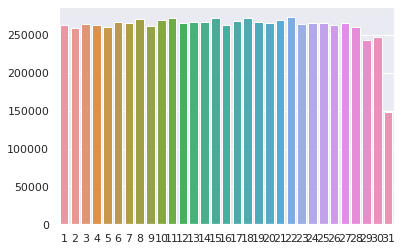

In [15]:
flights_years = df.DAY_OF_MONTH.value_counts()
sns.barplot(x=flights_years.index, y=flights_years.values)

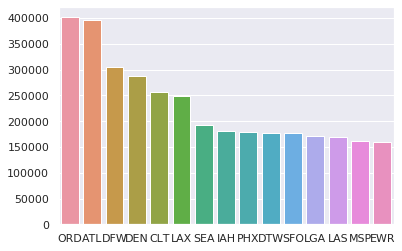

In [16]:
org = df.ORIGIN.value_counts().head(15)
sns.barplot(x=org.index, y=org.values)

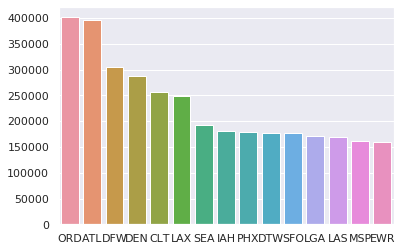

In [17]:
des = df.DEST.value_counts().head(15)
sns.barplot(x=des.index, y=des.values)

In [18]:
df1 = df
df1.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,...,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 29
YEAR,,,,,,,,,,,,,,,,,,,,,
2019,1,16,3,2019-01-16,AA,N150UW,544,BOS,PHL,537,...,78.0,61.0,1.0,280.0,NaN,NaN,NaN,NaN,NaN,NaN
2019,1,17,4,2019-01-17,AA,N563UW,544,BOS,PHL,537,...,97.0,66.0,1.0,280.0,NaN,NaN,NaN,NaN,NaN,NaN
2019,1,18,5,2019-01-18,AA,N921US,544,BOS,PHL,537,...,90.0,66.0,1.0,280.0,NaN,NaN,NaN,NaN,NaN,NaN
2019,1,19,6,2019-01-19,AA,N604AW,544,BOS,PHL,537,...,98.0,64.0,1.0,280.0,NaN,NaN,NaN,NaN,NaN,NaN
2019,1,20,7,2019-01-20,AA,N975UY,544,BOS,PHL,537,...,NaN,NaN,1.0,280.0,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
df1 = df1.drop(columns=['CRS_DEP_TIME',
       'DEP_TIME', 'DEP_DELAY', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY','DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE'])

In [20]:
df1['OP_UNIQUE_CARRIER'].value_counts().head()

WN    1363946
DL     991986
AA     946776
OO     836755
UA     625910
Name: OP_UNIQUE_CARRIER, dtype: int64

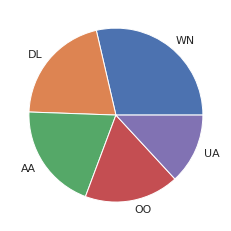

In [21]:
label = ['WN','DL','AA','OO','UA']
plt.pie(df1['OP_UNIQUE_CARRIER'].value_counts().head(), labels = label)
plt.show()

In [22]:
df1.groupby('ORIGIN').count().sort_values('CANCELLED', ascending=False).head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,DEST,CANCELLED,CANCELLATION_CODE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 29
ORIGIN,,,,,,,,,,,,,,,,
ORD,401576,401576,401576,401576,401576,398148,401576,401576,401576,12919,99207,99207,99207,99207,99207,0
ATL,395652,395652,395652,395652,395652,395329,395652,395652,395652,2400,61697,61697,61697,61697,61697,0
DFW,304809,304809,304809,304809,304809,304450,304809,304809,304809,7839,69923,69923,69923,69923,69923,0
DEN,286902,286902,286902,286902,286902,284558,286902,286902,286902,5887,65756,65756,65756,65756,65756,0
CLT,256440,256440,256440,256440,256440,256194,256440,256440,256440,4246,51730,51730,51730,51730,51730,0


In [23]:
df1=df['OP_UNIQUE_CARRIER'].value_counts()
df1

WN    1363946
DL     991986
AA     946776
OO     836755
UA     625910
YX     329596
MQ     327084
B6     297411
OH     288989
AS     264817
9E     257246
YV     227831
NK     204845
F9     135543
EV     134277
PT     123054
QX     121897
ZW     106894
G4     105305
CP      94209
HA      83891
G7      79063
AX      76000
C5      58052
EM       8833
KS       1474
Name: OP_UNIQUE_CARRIER, dtype: int64

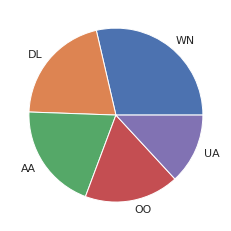

In [24]:
label = ['WN','DL','AA','OO','UA']
plt.pie(df['OP_UNIQUE_CARRIER'].value_counts().head(), labels = label)
plt.show()

In [25]:
df.groupby('ORIGIN').count().sort_values('CANCELLED', ascending=False)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,DEST,CRS_DEP_TIME,DEP_TIME,...,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 29
ORIGIN,,,,,,,,,,,,,,,,,,,,,
ORD,401576,401576,401576,401576,401576,398148,401576,401576,401576,389150,...,387584,387584,401576,401576,99207,99207,99207,99207,99207,0
ATL,395652,395652,395652,395652,395652,395329,395652,395652,395652,393303,...,392343,392343,395652,395652,61697,61697,61697,61697,61697,0
DFW,304809,304809,304809,304809,304809,304450,304809,304809,304809,297384,...,296166,296166,304809,304809,69923,69923,69923,69923,69923,0
DEN,286902,286902,286902,286902,286902,284558,286902,286902,286902,281288,...,280178,280178,286902,286902,65756,65756,65756,65756,65756,0
CLT,256440,256440,256440,256440,256440,256194,256440,256440,256440,252457,...,251584,251584,256440,256440,51730,51730,51730,51730,51730,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OWB,102,102,102,102,102,101,102,102,102,101,...,101,101,102,102,26,26,26,26,26,0
HYA,83,83,83,83,83,83,83,83,83,83,...,83,83,83,83,26,26,26,26,26,0
DLG,82,82,82,82,82,82,82,82,82,82,...,82,82,82,82,13,13,13,13,13,0


In [26]:
df2=df[['CRS_DEP_TIME','DEP_TIME','DEP_DELAY','CRS_ARR_TIME','ARR_TIME','ARR_DELAY',
            'CANCELLED','DIVERTED','CRS_ELAPSED_TIME','ACTUAL_ELAPSED_TIME','AIR_TIME','FLIGHTS','DISTANCE']]

In [28]:
df2.describe() 

,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE
count,8.091684e+06,7.943790e+06,7.943766e+06,8.091684e+06,7.934768e+06,7.917264e+06,8.091684e+06,8.091684e+06,8.091674e+06,7.917264e+06,7.917264e+06,8091684.0,8.091684e+06
mean,1.330287e+03,1.334864e+03,1.100731e+01,1.484759e+03,1.462580e+03,5.674681e+00,1.898604e-02,2.569428e-03,1.382580e+02,1.332411e+02,1.079366e+02,1.0,7.681613e+02
std,4.905830e+02,5.047288e+02,4.975387e+01,5.180583e+02,5.390499e+02,5.182652e+01,1.364755e-01,5.062437e-02,7.110732e+01,7.133880e+01,6.941984e+01,0.0,5.830837e+02
min,1.000000e+00,1.000000e+00,-8.700000e+01,1.000000e+00,1.000000e+00,-9.900000e+01,0.000000e+00,0.000000e+00,-1.430000e+02,1.500000e+01,4.000000e+00,1.0,3.100000e+01
25%,9.150000e+02,9.170000e+02,-6.000000e+00,1.100000e+03,1.047000e+03,-1.500000e+01,0.000000e+00,0.000000e+00,8.800000e+01,8.200000e+01,5.800000e+01,1.0,3.430000e+02
50%,1.322000e+03,1.327000e+03,-2.000000e+00,1.513000e+03,1.502000e+03,-6.000000e+00,0.000000e+00,0.000000e+00,1.200000e+02,1.150000e+02,8.900000e+01,1.0,6.050000e+02
75%,1.735000e+03,1.745000e+03,7.000000e+00,1.919000e+03,1.915000e+03,8.000000e+00,0.000000e+00,0.000000e+00,1.680000e+02,1.630000e+02,1.370000e+02,1.0,1.001000e+03
max,2.359000e+03,2.400000e+03,2.976000e+03,2.400000e+03,2.400000e+03,2.973000e+03,1.000000e+00,1.000000e+00,1.509000e+03,1.604000e+03,1.557000e+03,1.0,5.095000e+03


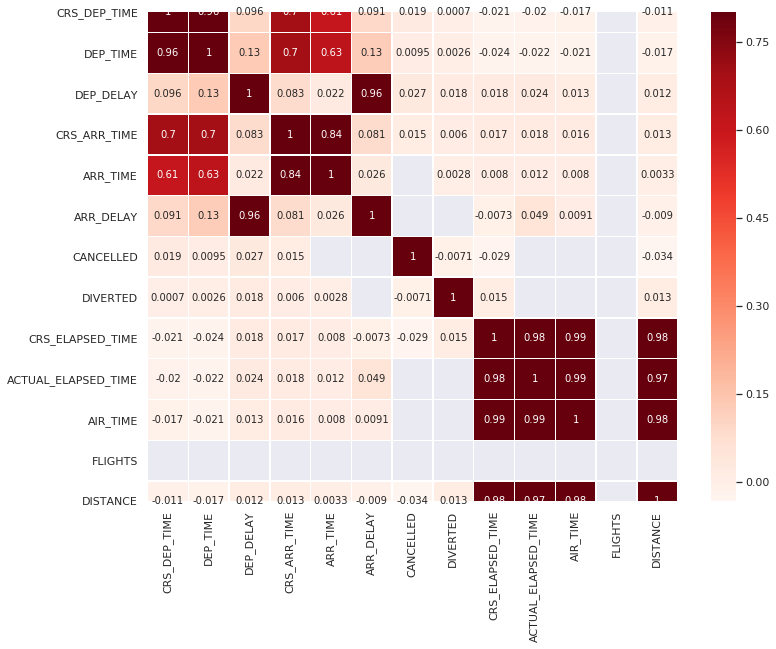

In [29]:
cormat = df2.corr()
round(cormat,2)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(cormat, cmap="Reds", vmax=0.8, square=True, linewidths=0.5,annot=True);

In [30]:
cormat.iloc[-1]

CRS_DEP_TIME          -0.011491
DEP_TIME              -0.016694
DEP_DELAY              0.012439
CRS_ARR_TIME           0.012780
ARR_TIME               0.003274
ARR_DELAY             -0.009012
CANCELLED             -0.033531
DIVERTED               0.013172
CRS_ELAPSED_TIME       0.982527
ACTUAL_ELAPSED_TIME    0.966896
AIR_TIME               0.983554
FLIGHTS                     NaN
DISTANCE               1.000000
Name: DISTANCE, dtype: float64

In [31]:
import networkx as nx
FG = nx.from_pandas_edgelist(df, source='ORIGIN', target='DEST', edge_attr=True,)

In [32]:
#FG.node()

In [33]:
#FG.edges()

/home/ood.discovery.neu.edu/software/anaconda3/2019.10/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


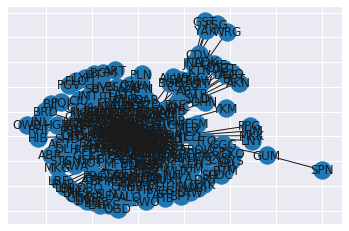

In [34]:
nx.draw_networkx(FG, with_labels=True) 

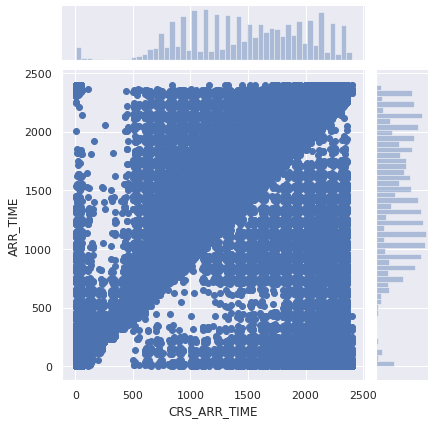

In [35]:
sns.jointplot(data=df, x="CRS_ARR_TIME", y="ARR_TIME")

In [36]:
#Arrival & Departure Delays
airline_rank_v07 = pd.DataFrame({'avg_arrival_delay' : df.groupby(['OP_UNIQUE_CARRIER'])['ARR_DELAY'].mean()}).reset_index()
airline_rank_v08 = pd.DataFrame({'avg_departure_delay' : df.groupby(['OP_UNIQUE_CARRIER'])['DEP_DELAY'].mean()}).reset_index()

In [37]:
airline07=airline_rank_v07.sort_values(by=['avg_arrival_delay'], ascending=False).head(15)
airline07

,OP_UNIQUE_CARRIER,avg_arrival_delay
14,KS,25.063248
5,C5,24.724862
3,AX,17.462860
9,EV,15.515935
12,G7,11.541344
4,B6,11.223514
23,YV,10.465467
10,F9,8.715867
21,UA,8.289444
11,G4,8.005639


In [38]:
airline08=airline_rank_v08.sort_values(by=['avg_departure_delay'], ascending=False).head(15)
airline08

,OP_UNIQUE_CARRIER,avg_departure_delay
5,C5,26.970640
14,KS,25.222867
3,AX,19.460296
4,B6,17.745473
9,EV,17.222656
12,G7,16.968620
10,F9,14.577009
23,YV,13.803718
21,UA,13.004564
18,OO,12.592552


[Text(0.5, 0, 'delay_time (arrival: red, departure: blue)')]

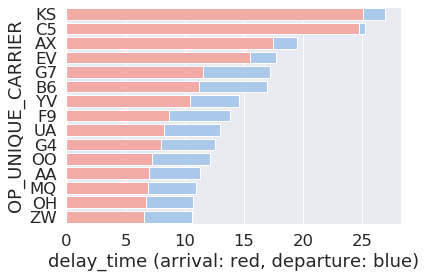

In [39]:
ax = sns.set_color_codes("pastel")
sns.set_context("notebook", font_scale=1.5)
ax = sns.barplot(x="avg_departure_delay", y="OP_UNIQUE_CARRIER", data=airline08,
            label="accuracy", color="b")
ax = sns.barplot(x="avg_arrival_delay", y="OP_UNIQUE_CARRIER", data=airline07,
            label="accuracy", color="r")
ax.set(xlabel="delay_time (arrival: red, departure: blue)")

In [40]:
df3=df.drop(columns=[ 'TAIL_NUM','OP_CARRIER_FL_NUM', 'FL_DATE','OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 
                     'CANCELLATION_CODE','Unnamed: 29','DEP_TIME', 'DEP_DELAY','ARR_TIME',
                    'ACTUAL_ELAPSED_TIME','FLIGHTS'])

In [41]:
df3.columns

Index(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'CRS_DEP_TIME', 'CRS_ARR_TIME',
       'ARR_DELAY', 'CANCELLED', 'DIVERTED', 'CRS_ELAPSED_TIME', 'AIR_TIME',
       'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'],
      dtype='object')

In [42]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8091684 entries, 2019 to 2019
Data columns (total 16 columns):
MONTH                  int64
DAY_OF_MONTH           int64
DAY_OF_WEEK            int64
CRS_DEP_TIME           int64
CRS_ARR_TIME           int64
ARR_DELAY              float64
CANCELLED              float64
DIVERTED               float64
CRS_ELAPSED_TIME       float64
AIR_TIME               float64
DISTANCE               float64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
NAS_DELAY              float64
SECURITY_DELAY         float64
LATE_AIRCRAFT_DELAY    float64
dtypes: float64(11), int64(5)
memory usage: 1.0 GB


In [43]:
# replacing all NaN values with the mean of the attribute in which they are present
df3=df3.fillna(df3.mean())

In [44]:
# creating a new column; it will tell if the flight was delayed or not
result=[]

In [45]:
for row in df3['ARR_DELAY']:
  if row > 15:
    result.append(1)
  else:
    result.append(0)  

In [46]:
df3['result'] = result

In [47]:
df3['result'].value_counts()

0    6614749
1    1476935
Name: result, dtype: int64

In [54]:
#### Decision Tree model  ####

# splitting in the ratio 80:20
data = df3.values
X, y = data[:,:-1], data[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=43)  

In [55]:
scaled_features = StandardScaler().fit_transform(X_train, X_test)

In [56]:
#Applying Decision Tree Classifier on Training Data
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)

In [57]:
#Making Predictions and Checking Accuracy
pred_prob = clf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, pred_prob[:,1])
auc_score

1.0

In [48]:
df4=df3.drop(['ARR_DELAY' ],axis=1)

In [49]:
df4.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,CRS_ARR_TIME,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,result
YEAR,,,,,,,,,,,,,,,,
2019,1,16,3,537,713,0.0,0.0,96.0,61.000000,280.0,21.152429,3.744566,16.59292,0.08938,28.109625,0
2019,1,17,4,537,713,0.0,0.0,96.0,66.000000,280.0,21.152429,3.744566,16.59292,0.08938,28.109625,0
2019,1,18,5,537,713,0.0,0.0,96.0,66.000000,280.0,21.152429,3.744566,16.59292,0.08938,28.109625,0
2019,1,19,6,537,713,0.0,0.0,96.0,64.000000,280.0,21.152429,3.744566,16.59292,0.08938,28.109625,0
2019,1,20,7,537,713,1.0,0.0,96.0,107.936603,280.0,21.152429,3.744566,16.59292,0.08938,28.109625,0


In [50]:
#### Decision Tree model optimization  ####

# splitting in the ratio 80:20
data = df4.values
X, y = data[:,:-1], data[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=43)  

In [51]:
scaled_features = StandardScaler().fit_transform(X_train, X_test)

In [52]:
#Applying Decision Tree Classifier on Training Data
clf = DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=5)
clf = clf.fit(X_train,y_train)

In [53]:
#Making Predictions and Checking Accuracy
pred_prob = clf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, pred_prob[:,1])
auc_score

0.9997688021647751